# Draw an isochrone map with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

How far can you travel on foot in 15 minutes?

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import shapely
from shapely import MultiPolygon

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
# configure the place, network type, trip times, and travel speed
network_type = 'walk'
trip_times = [5, 10, 15, 20] #in minutes
travel_speed = 4 #walking speed in km/hour

In [5]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)

## Getting data

In [6]:
metro_df = pd.read_csv('data/metro-exits-2024-12-18.csv', delimiter=';')
del metro_df['Unnamed: 21']
metro_df.head()

,Локальный идентификатор,Наименование,На территории Москвы,Административный округ,Район,Долгота в WGS-84,Широта в WGS-84,Тип вестибюля,Станция метрополитена,Линия,...,Режим работы по чётным дням,Режим работы по нечётным дням,Количество полнофункциональных БПА (все типы билетов),Количество малофункциональных БПА (билеты на 1 и 2 поездки),Общее количество БПА,Ремонт эскалаторов,Статус объекта,global_id,geoData,geodata_center
0,331,"Китай-город, вход-выход 5 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631765,55.757328,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773539,"{coordinates=[37.63176509, 55.75732811], type=...","{coordinates=[37.63176509, 55.75732811], type=..."
1,327,"Китай-город, вход-выход 4 в северный вестибюль",да,Центральный административный округ,Тверской район,37.630924,55.756733,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773540,"{coordinates=[37.63092407, 55.75673268], type=...","{coordinates=[37.63092407, 55.75673268], type=..."
2,330,"Китай-город, вход-выход 7 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631862,55.757027,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773541,"{coordinates=[37.63186197, 55.75702717], type=...","{coordinates=[37.63186197, 55.75702717], type=..."
3,322,"Китай-город, вход-выход 13 в южный вестибюль",да,Центральный административный округ,Тверской район,37.633207,55.752999,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773542,"{coordinates=[37.63320674, 55.7529987], type=P...","{coordinates=[37.63320674, 55.7529987], type=P..."
4,321,"Китай-город, вход-выход 12 в южный вестибюль",да,Центральный административный округ,Таганский район,37.633566,55.753071,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773543,"{coordinates=[37.63356616, 55.75307131], type=...","{coordinates=[37.63356616, 55.75307131], type=..."


In [7]:
metro_df = metro_df[metro_df['Линия'] != 'Московская монорельсовая транспортная система']

In [195]:
metro_df['Линия'].value_counts()

Линия
Таганско-Краснопресненская линия    124
Сокольническая линия                122
Калужско-Рижская линия              117
Серпуховско-Тимирязевская линия     117
Замоскворецкая линия                108
Люблинско-Дмитровская линия          99
Большая кольцевая линия              97
Арбатско-Покровская линия            78
Московское центральное кольцо        73
Солнцевская линия                    50
Калининская линия                    39
Некрасовская линия                   32
Кольцевая линия                      30
Филёвская линия                      27
Бутовская линия Лёгкого метро        11
Троицкая линия                       10
Name: count, dtype: int64

In [8]:
metro_df = metro_df.iloc[:, [5, 6, 8, 9]]
metro_df.head()

,Долгота в WGS-84,Широта в WGS-84,Станция метрополитена,Линия
0,37.631765,55.757328,Китай-город,Калужско-Рижская линия
1,37.630924,55.756733,Китай-город,Калужско-Рижская линия
2,37.631862,55.757027,Китай-город,Калужско-Рижская линия
3,37.633207,55.752999,Китай-город,Калужско-Рижская линия
4,37.633566,55.753071,Китай-город,Калужско-Рижская линия


In [152]:
metro_df[metro_df['Станция метрополитена'] == 'Мнёвники'].iloc[:, [0, 1]].mean()

Долгота в WGS-84    37.472022
Широта в WGS-84     55.761102
dtype: float64

In [153]:
metro_df[metro_df['Станция метрополитена'] == 'Мнёвники'].iloc[:, [0, 1]].to_numpy()

array([[37.47138012, 55.76026171],
       [37.47172881, 55.76017096],
       [37.47233066, 55.76200533],
       [37.47264716, 55.76196903]])

In [9]:
stations = list(set([x[0] + '_' + x[1] for x in metro_df.iloc[:, [2, 3]].values.tolist()]))
stations[:5]

['Давыдково_Большая кольцевая линия',
 'Волоколамская_Арбатско-Покровская линия',
 'Третьяковская_Калининская линия',
 'Мичуринский проспект_Большая кольцевая линия',
 'Войковская_Замоскворецкая линия']

In [10]:
len(stations)

295

## Download and prep the street network

In [11]:
MARGIN = 500 # m
CRS = "EPSG:4326"

def get_graph_and_nodes(station, df, trip_times):
    st_name, st_line = list(station.split('_'))
    station_df = df[(df['Станция метрополитена'] == st_name) & (df['Линия'] == st_line)].iloc[:, [0, 1]]
    coords = station_df.mean()
    station_coords = coords[1], coords[0]

    meters_per_minute = travel_speed * 1000 / 60 # km per hour to m per minute
    G = ox.graph_from_point(station_coords, dist=meters_per_minute * max(trip_times) + MARGIN, dist_type='network',
                            network_type=network_type, simplify=False)

    gdf_nodes = ox.graph_to_gdfs(G, edges=False)

    exits = station_df.to_numpy()

    G = ox.project_graph(G, to_crs=CRS)
    exit_nodes = [ox.distance.nearest_nodes(G, exit[0], exit[1]) for exit in exits]
    G = ox.project_graph(G)

    for u, v, k, data in G.edges(data=True, keys=True):
        data['time'] = data['length'] / meters_per_minute

    return G, exit_nodes

In [12]:
def make_iso_polys(G, center_node, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).union_all()

        g_node = G.nodes(data=True)[center_node]
        if type(new_iso) != Polygon:
            new_iso = Polygon([(g_node['x'], g_node['y'])]*4)

        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [13]:
def show_isochrones(G, isochrones, iso_colors):
    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                                node_size=0, bgcolor='k')
    
    for polygon, fc in zip(isochrones, iso_colors):
        for geom in polygon.geoms:    
            xs, ys = geom.exterior.xy 
            ax.fill(xs, ys, fc=fc, ec='none', alpha=0.6, zorder=-1)
    
    plt.show()

In [26]:
with open('data/isochrones.pickle', 'rb') as f:
    station_to_isochrones = pickle.load(f)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

================= Давыдково Большая кольцевая линия =================


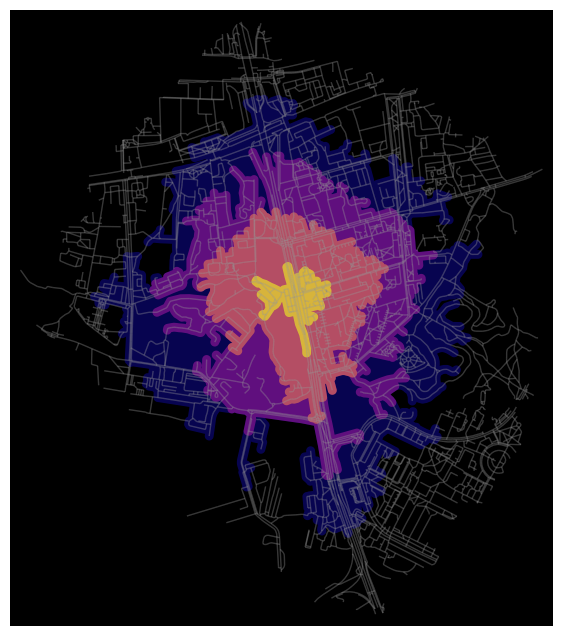

 20%|████████████████▊                                                                   | 1/5 [00:09<00:39,  9.94s/it]

================= Волоколамская Арбатско-Покровская линия =================


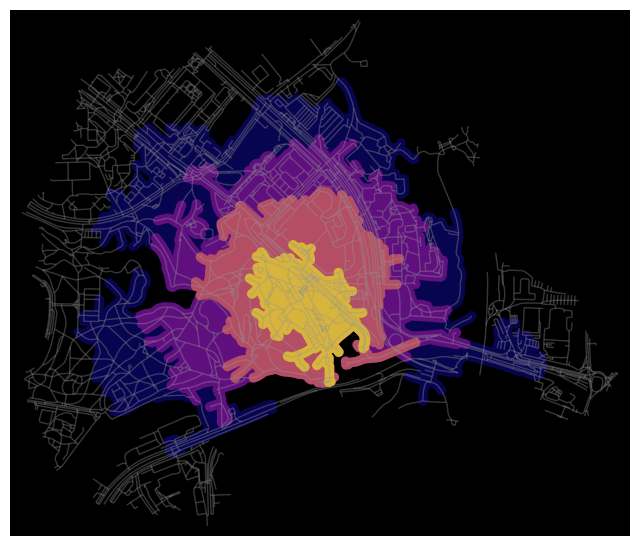

 40%|█████████████████████████████████▌                                                  | 2/5 [00:21<00:33, 11.16s/it]

================= Третьяковская Калининская линия =================


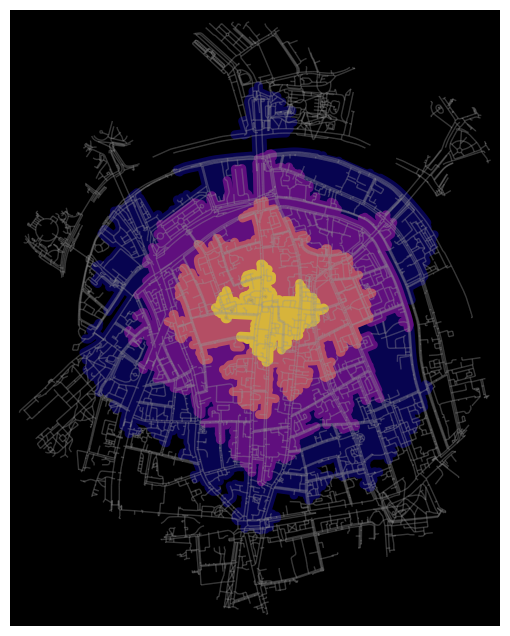

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:46<00:34, 17.17s/it]

================= Мичуринский проспект Большая кольцевая линия =================


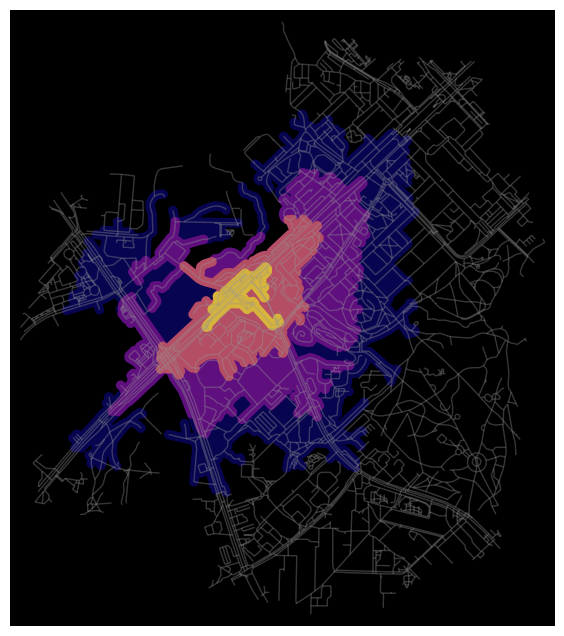

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:58<00:15, 15.09s/it]

================= Войковская Замоскворецкая линия =================


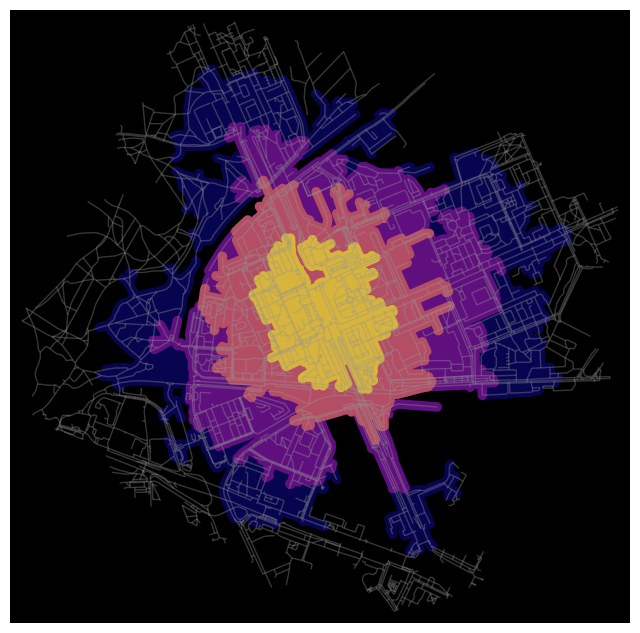

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.05s/it]


In [28]:
for station in tqdm(stations[:5]):
    print(f'================= {station.replace("_", ", ")} =================')
    G, exit_nodes = get_graph_and_nodes(station, metro_df, trip_times)

    if station not in station_to_isochrones.keys():
        exits_isochrones = []
        for exit_node in exit_nodes:
            isochrone_polys = make_iso_polys(G, exit_node, edge_buff=25, node_buff=0, infill=True)
            # print(isochrone_polys)
            exits_isochrones.append(isochrone_polys)
            # show_isochrones(G, isochrone_polys, iso_colors)
    
        station_isochrones = []
        for i in range(len(trip_times)):
            iso = shapely.union_all([iso_polys[i] for iso_polys in exits_isochrones])
            if type(iso) != MultiPolygon:
                iso = MultiPolygon([iso])
            station_isochrones.append(iso)
        print(station_isochrones)

        station_to_isochrones[station] = station_isochrones
        with open('data/isochrones.pickle', 'wb') as f:
             pickle.dump(station_to_isochrones, f)
    else:
        station_isochrones = station_to_isochrones[station]

    show_isochrones(G, station_isochrones, iso_colors)

In [24]:
mapa = [shapely.union_all([x[i] for x in list(station_to_isochrones.values())]) for i in range(len(trip_times))]
mapa

[<MULTIPOLYGON (((403858.474 6171647.106, 403858.452 6171647.14, 403858.427 6...>,
 <MULTIPOLYGON (((403978.447 6171882.301, 403977.16 6171884.39, 403976.083 61...>,
 <MULTIPOLYGON (((404282.464 6172095.398, 404281.292 6172095.404, 404281.237 ...>,
 <MULTIPOLYGON (((404721.467 6172410.641, 404721.324 6172410.555, 404721.028 ...>]

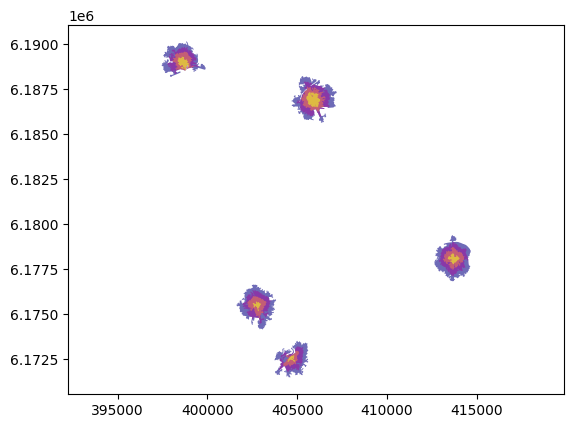

In [25]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for polygon, fc in zip(mapa, iso_colors):
    for geom in polygon.geoms:    
        xs, ys = geom.exterior.xy 
        axs.fill(xs, ys, fc=fc, ec='none', alpha=0.6, zorder=-1)

plt.show()